In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/product-test/Test Samples Classification/7/7.png
/kaggle/input/product-test/Test Samples Classification/19/1.png
/kaggle/input/product-test/Test Samples Classification/2/4.png
/kaggle/input/product-test/Test Samples Classification/2/1.png
/kaggle/input/product-test/Test Samples Classification/2/2.png
/kaggle/input/product-test/Test Samples Classification/2/3.png
/kaggle/input/product-test/Test Samples Classification/10/1.png
/kaggle/input/product-test/Test Samples Classification/5/1.png
/kaggle/input/product-test/Test Samples Classification/5/2.png
/kaggle/input/product-test/Test Samples Classification/5/3.png
/kaggle/input/product-test/Test Samples Classification/20/4.png
/kaggle/input/product-test/Test Samples Classification/20/1.png
/kaggle/input/product-test/Test Samples Classification/20/2.png
/kaggle/input/product-test/Test Samples Classification/20/3.png
/kaggle/input/product-test/Test Samples Classification/16/1.png
/kaggle/input/product-test/Test Samples Classifi

In [5]:
from pathlib import Path
Path('/kaggle/working/train_destination').mkdir(parents=True, exist_ok=True)
Path('/kaggle/working/validate_destination').mkdir(parents=True, exist_ok=True)

In [6]:
#os.remove('Trained Models/basic_CNN_Model.h5')
#os.remove('Trained Models/basic_CNN_Model_ExtraTrain.h5')

In [7]:
import cv2
import os
import shutil

def apply_bilateral_filter(image):
    return cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)

# Specify the path to your dataset
dataset_dir = '/kaggle/input/dataest/Product Classification'

# Specify the destination folders for train and validate sets
train_destination = '/kaggle/working/train_destination'
validate_destination = '/kaggle/working/validate_destination'

# Create the destination folders if they don't exist
os.makedirs(train_destination, exist_ok=True)
os.makedirs(validate_destination, exist_ok=True)

# Loop through the numbered folders (1 to 20)
for product_folder in range(1, 21):
    # Path to the current product's train folder
    train_folder_path = os.path.join(dataset_dir, str(product_folder), 'Train')

    # Path to the current product's validate folder
    validate_folder_path = os.path.join(dataset_dir, str(product_folder), 'Validation')

    # Check if the train folder exists for the current product
    if os.path.exists(train_folder_path):
        #print(f"Train folder exists for product {product_folder}")
        
        # Rest of the code
        # Loop through images in the train folder
        for image_file in os.listdir(train_folder_path):
            image_path = os.path.join(train_folder_path, image_file)
            image = cv2.imread(image_path)

            # Apply bilateral filter
            filtered_image = apply_bilateral_filter(image)

            # Save the filtered image to the train destination
            filtered_image_path = os.path.join(train_destination, f'product_{product_folder}_{image_file}')
            cv2.imwrite(filtered_image_path, filtered_image)

    # Check if the validate folder exists for the current product
    if os.path.exists(validate_folder_path):
        #print(f"validate folder exists for product {product_folder}")
       
        # Rest of the code
        # Loop through images in the validate folder
        for image_file in os.listdir(validate_folder_path):
            image_path = os.path.join(validate_folder_path, image_file)
            image = cv2.imread(image_path)

            # Apply bilateral filter
            filtered_image = apply_bilateral_filter(image)

            # Save the filtered image to the validate destination
            filtered_image_path = os.path.join(validate_destination, f'product_{product_folder}_{image_file}')
            cv2.imwrite(filtered_image_path, filtered_image)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


In [8]:
import cv2
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def apply_bilateral_filter(image):
    return cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)

def extract_sift_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    return descriptors

def build_codebook(features, k=100):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(features)
    return kmeans

def image_to_hist(image, kmeans):
    sift = cv2.SIFT_create()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)

    # Check if any descriptors were found
    if descriptors is not None and descriptors.shape[0] > 0:
        # Assign visual words to descriptors
        labels = kmeans.predict(descriptors)

        # Count the occurrences of each visual word
        hist = np.bincount(labels, minlength=len(kmeans.cluster_centers_))

        return hist
    else:
        # Return an empty histogram if no descriptors were found
        return np.zeros(len(kmeans.cluster_centers_))

# Specify the path to your dataset
dataset_dir = '/kaggle/input/dataest/Product Classification'

# Specify the destination folders for train and validate sets
train_destination = '/kaggle/working/train_destination'
validate_destination = '/kaggle/working/validate_destination'

# Create the destination folders if they don't exist
os.makedirs(train_destination, exist_ok=True)
os.makedirs(validate_destination, exist_ok=True)

# Number of clusters (visual words) for the codebook
k = 100

# Collect SIFT features from training images
all_train_features = []

# Loop through the numbered folders (1 to 20)
for product_folder in range(1, 21):
    # Path to the current product's train folder
    train_folder_path = os.path.join(dataset_dir, str(product_folder), 'Train')

    # Check if the train folder exists for the current product
    if os.path.exists(train_folder_path):
        # Loop through images in the train folder
        for image_file in os.listdir(train_folder_path):
            image_path = os.path.join(train_folder_path, image_file)
            image = cv2.imread(image_path)

            # Apply bilateral filter
            filtered_image = apply_bilateral_filter(image)

            # Extract SIFT features
            features = extract_sift_features(filtered_image)
            all_train_features.extend(features)

# Build the codebook using KMeans
kmeans = build_codebook(np.array(all_train_features), k)

# Loop through the numbered folders (1 to 20) for training set
for product_folder in range(1, 21):
    # Path to the current product's train folder
    train_folder_path = os.path.join(dataset_dir, str(product_folder), 'Train')

    # Check if the train folder exists for the current product
    if os.path.exists(train_folder_path):
        # Loop through images in the train folder
        for image_file in os.listdir(train_folder_path):
            image_path = os.path.join(train_folder_path, image_file)
            image = cv2.imread(image_path)

            # Apply bilateral filter
            filtered_image = apply_bilateral_filter(image)

            # Convert the image to a histogram of visual words
            hist = image_to_hist(filtered_image, kmeans)

            # Extract product folder number
            product_folder_number = str(product_folder)

            # Save the histogram to the train destination with the desired name format
            hist_name = f'{product_folder_number}_hist.npy'
            hist_path = os.path.join(train_destination, hist_name)
            np.save(hist_path, hist)

# Loop through the numbered folders (1 to 20) for the validation set
for product_folder in range(1, 21):
    # Path to the current product's validation folder
    validate_folder_path = os.path.join(dataset_dir, str(product_folder), 'Validation')

    # Check if the validation folder exists for the current product
    if os.path.exists(validate_folder_path):
        # Loop through images in the validation folder
        for image_file in os.listdir(validate_folder_path):
            image_path = os.path.join(validate_folder_path, image_file)
            image = cv2.imread(image_path)

            # Apply bilateral filter
            filtered_image = apply_bilateral_filter(image)

            # Convert the image to a histogram of visual words
            hist = image_to_hist(filtered_image, kmeans)

            # Extract product folder number
            product_folder_number = str(product_folder)

            # Save the histogram to the validation destination with the desired name format
            hist_name = f'{product_folder_number}_hist.npy'
            hist_path = os.path.join(validate_destination, hist_name)
            np.save(hist_path, hist)
import os
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Specify the destination folders for train and validate sets
train_destination = '/kaggle/working/train_destination'
validate_destination = '/kaggle/working/validate_destination'

# Load histograms and labels for training set
train_data = []
train_labels = []

for product_folder in range(1, 21):
    # Load histograms for the training set
    hist_path_train = os.path.join(train_destination, f'{product_folder}_hist.npy')
    hist_train = np.load(hist_path_train)

    # Append histograms and labels for training set
    train_data.append(hist_train)
    train_labels.extend([product_folder] * hist_train.shape[0])

train_data = np.concatenate(train_data, axis=0)
train_labels = np.array(train_labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

# Reshape the data before applying the scaler
X_train_reshaped = X_train.reshape(-1, 1)
X_test_reshaped = X_test.reshape(-1, 1)

# Use StandardScaler to normalize the data
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train_reshaped)
X_test_normalized = scaler.transform(X_test_reshaped)


print("Shapes after normalization:")
print("X_train_normalized shape:", X_train_normalized.shape)
print("y_train shape:", y_train.shape)
print("X_test_normalized shape:", X_test_normalized.shape)
print("y_test shape:", y_test.shape)

# Train the SVM classifier
clf = svm.SVC(kernel='linear')
clf.fit(X_train_normalized, y_train)

# Predict on the normalized test set
y_pred = clf.predict(X_test_normalized)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print some predictions and actual labels for debugging
print("Predictions:", y_pred)
print("Actual Labels:", y_test)

print("Labels:")
print("Unique train labels:", np.unique(y_train))
print("Unique test labels:", np.unique(y_test))
print("Unique predicted labels:", np.unique(y_pred))

print("\nHistograms:")


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Shapes after normalization:
X_train_normalized shape: (1600, 1)
y_train shape: (1600,)
X_test_normalized shape: (400, 1)
y_test shape: (400,)
Accuracy: 9.25%
Predictions: [10  9 13 10  9 13  1 13 10  9  1 13 10 14 13 14  9 13 13 13 10 10 14  9
 14  9  9 10 14  1 14 10 13 10 13  9  9 13  9  9 13 14  9 13  9 13  9 14
  9 14 13 13 13  9 14  9 13  9  9 14 13  9 14 13  9 10 10 14 14  9 13 10
  9 14 10 10  9 10 13  1 14 13 13  9 13 13  9 13 13 13 13 10  1 13  9  9
 13 13 13 10 10  1 14 14  9 13 13 10  9  9 10  9 14 14 10 14 10  9  9  9
 13  1 13 10 13 14 10 13  9 13  9 10 14 13  9 13  1  9 13  9 14 10 13 13
 14 13 13 13 14 10 13 10  9  9  9  9  9  9 13 13 13 13 14 13  9 13 14  9
  9 13 13 13 14 13  1 13 10 14  9  9  9 14 14 13 13  1  9 13 13 13 13  9
 14 13  1 13  9  9 13 13  9  9 13 10 13 13 13 14 13 14 13  1 13 14 10  9
 13 10  9  9 10  9 13 13  9 13  9 10 13 14  9  9 13 13 13  9 13 13 10 13
 10 13 13 14 13 13 14  9 14 10 13  9 10 10 13 13 13 10  9 13 10 13  9 13
 13  9 14  9 10 13 14 10  

In [9]:
#class HOG
import os
import cv2
import numpy as np
from random import shuffle
dataset_dir = '/kaggle/input/dataest/Product Classification'
data_path = dataset_dir


def get_dataset(data_path,model_type, image_size):
    train_data_path, test_data_path = get_images_paths(data_path)

    train_data = read_images(train_data_path, model_type, image_size)
    test_data = read_images(test_data_path, model_type, image_size)

    shuffle(train_data)

    return train_data, test_data


def get_images_paths(data_path):
    train_images_path = []
    test_images_path = []

    for class_folder in os.listdir(data_path):
        for sub_folder in os.listdir(data_path +'/'+ class_folder):
            for img in os.listdir(data_path +'/'+ class_folder + '/' + sub_folder):

                image_path = os.path.join(data_path +'/'+ class_folder + '/' + sub_folder, img)
                if image_path.endswith(".csv"):
                    continue

                if sub_folder == 'Train':
                    train_images_path.append(image_path)
                else:
                    test_images_path.append(image_path)
                    
    #print(train_images_path)
    return train_images_path, test_images_path


def read_images(images_paths, model_type, image_size):
    images = []

    for i in images_paths:
        image = cv2.imread(i, 0)
        image = resize_image(image, image_size, model_type)

        image_label = create_label(i)
        images.append([np.array(image), image_label])

    return images


def resize_image(image, image_size, model_type):
    if model_type == 'HOG':
        return cv2.resize(image, (image_size, 2 * image_size))
    else:
        return cv2.resize(image, (image_size, image_size))


def create_label(image_path):
    image_label = image_path.split('/')[5]
    image_Classes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
    label_encoded = np.zeros((20, 1))

    for i in range(len(image_Classes)):
        if image_label == str(i+1):
            label_encoded[i] = 1

    
    return label_encoded





In [10]:
#class CNN
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
import os
import keras
import cv2
class CNN:
    
    image_Classes = ['1', '2', '3', '4', '5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']


    def generate_CNN_model(train_data):
        X_train, Y_train = CNN.reformat_dataset(train_data, image_size=128)
        model = CNN.buildSequentialModel()

        if os.path.exists('Trained Models/basic_CNN_Model.h5'):
            model = keras.models.load_model('Trained Models/basic_CNN_Model.h5')
        else:
            model.fit(X_train, Y_train, validation_split=0.2, epochs=20)
            prediction=model.predict(X_train)
            Y_true, prediction = CNN.reformat_labels(Y_train, prediction)
            print("Train Accuracy: " + str(accuracy_score(Y_true, prediction)))

            model.save('Trained Models/basic_CNN_Model.h5')

        return model

    #to be study
    def reformat_dataset(data, image_size):
        X = np.array([i[0] for i in data], dtype=object).reshape(-1, image_size, image_size, 1)
        Y = np.array([i[1] for i in data])
        Y = Y.reshape(len(Y), 20)

        X = np.asarray(X).astype(np.float32)
        return X, Y


    def buildSequentialModel():
        model = tf.keras.Sequential([
            layers.Input(shape=(128, 128, 1)),
            layers.Conv2D(32, 5, strides=2, activation='relu'),
            layers.Conv2D(32, 5, activation='relu'),
            layers.MaxPool2D((3, 3)),
            layers.Conv2D(32, 5, strides=2, activation='relu'),
            layers.Conv2D(32, 5, activation='relu'),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(20, activation='softmax')
        ])

        model.summary()
        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model


    def test_model(test_data, model, visualise=False):
        X_test, Y_test = CNN.reformat_dataset(test_data, image_size=128)
        predictions = model.predict(X_test)
        print("Shape of predictions:", predictions.shape)

        y_true, predictions = CNN.reformat_labels(Y_test, predictions)
        print("Testing Accuracy: " + str(accuracy_score(y_true, predictions)))
        matrix = confusion_matrix(y_true, predictions)

        disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
        disp.plot()
        plt.show()

        if visualise:
            CNN.Visualise_data(test_data, predictions)


    def Visualise_data(data, predictions):
        for i in range(len(data)):
            plt.imshow(cv2.cvtColor(data[i][0], cv2.COLOR_BGR2RGB))
            plt.title("Prediction is " + str(image_Classes[predictions[i]]))
            plt.show()


    def reformat_labels(y_true, y_test):
        true = []
        prediction = []
        for i in range(len(y_true)):
            true.append(np.argmax(y_true[i]))
            prediction.append(np.argmax(y_test[i]))
        return true, prediction

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 19, 19, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          25632     
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 32)          25632     
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                        

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 9ms/step
Shape of predictions: (34, 20)
Testing Accuracy: 0.7058823529411765


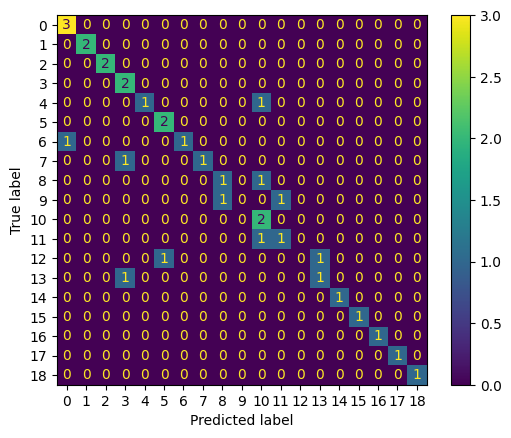

In [12]:

#train and test(validation) accuracy for CNN

train_data, test_data = get_dataset(data_path,model_type='CNN', image_size=128)

model = CNN.generate_CNN_model(train_data)

CNN.test_model(test_data, model, visualise=False)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 25ms/step
Shape of predictions: (42, 20)
Testing Accuracy: 0.11904761904761904


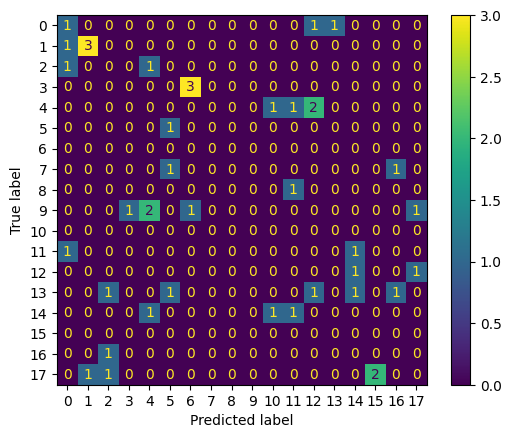

In [13]:
#accuracy on validation set
test='/kaggle/input/product-test'
train_data, test_data = get_dataset(test,model_type='CNN', image_size=128)

model = keras.models.load_model('Trained Models/basic_CNN_Model.h5')

CNN.test_model(test_data, model, visualise=False)

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from joblib import dump, load
import os
import cv2
class HOG:
    
    image_Classes = ['1', '2', '3', '4', '5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']

    # Specify the directory for train path
    directory_path = '/Trained Models/'

    # Create the directory if it doesn't exist
    os.makedirs(directory_path, exist_ok=True)

    def generate_HOG_model(train_data):
        X_train, Y_train = HOG.generate_hog_features(train_data)

        if os.path.exists('/Trained Models/HOG_model.joblib'):
            clf = load('/Trained Models/HOG_model.joblib')
        else:
            clf = LogisticRegression().fit(X_train, Y_train)
            dump(clf, os.path.join(HOG.directory_path, 'HOG_model.joblib'))

        return clf


    def generate_hog_features(data):
        hog_features = []
        images_labels = []

        for i in data:
            fd = hog(i[0], orientations=9, pixels_per_cell=(8, 8),
                     cells_per_block=(2, 2), visualize=False)

            hog_features.append(fd)
            images_labels.append(HOG.reformat_label(i[1]))

        return np.array(hog_features), np.array(images_labels)


    def reformat_label(image_label):
        return np.argmax(image_label)


    def testModel(test_data, clf, visualise=False):
        X_test, Y_test = HOG.generate_hog_features(test_data)
        predictions = clf.predict(X_test)

        print("Testing Accuracy: " + str(accuracy_score(Y_test, predictions)))

        matrix = confusion_matrix(Y_test, predictions)

        disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
        disp.plot()
        plt.show()

        if visualise:
            HOG.Visualise_data(test_data, predictions)


    def Visualise_data(data, predictions):
        for i in range(len(data)):
            plt.imshow(cv2.cvtColor(data[i][0], cv2.COLOR_BGR2RGB))
            plt.title("Prediction is " + str(image_Classes[predictions[i]]))
            plt.show()

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Testing Accuracy: 0.7647058823529411


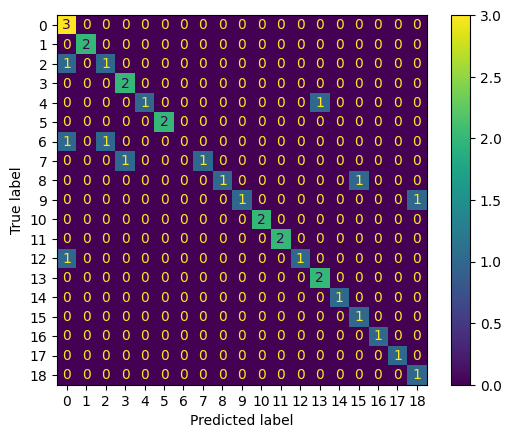

In [15]:
#accracy on validation set for hog
import time

train_data, test_data = get_dataset(data_path,model_type='HOG', image_size=64)

training_start_time = time.time()
clf = HOG.generate_HOG_model(train_data)
training_stop_time = time.time()

testing_start_time = time.time()
HOG.testModel(test_data, clf, visualise=False)
testing_stop_time = time.time()

#print(f"Training time: {training_stop_time - training_start_time}s")
#print(f"Testing time: {testing_stop_time - testing_start_time}s")

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Testing Accuracy: 0.2619047619047619


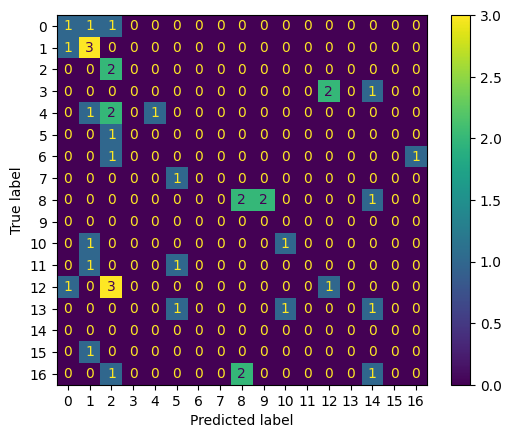

In [18]:
#test script for hog
test='/kaggle/input/product-test'
train_data, test_data = get_dataset(test,model_type='HOG', image_size=64)
clf = HOG.generate_HOG_model(train_data)
HOG.testModel(test_data, clf, visualise=False)

In [19]:
#fitting CNN with validation set
train_images_path2 = []
for class_folder in os.listdir(data_path):
        for sub_folder in os.listdir(data_path +'/'+ class_folder):
            for img in os.listdir(data_path +'/'+ class_folder + '/' + sub_folder):

                image_path = os.path.join(data_path +'/'+ class_folder + '/' + sub_folder, img)
                if image_path.endswith(".csv"):
                    continue

                if sub_folder == 'Validation':
                    train_images_path2.append(image_path)
train_data2 = read_images(train_images_path2, 'CNN', 128)
shuffle(train_data2)
model = keras.models.load_model('Trained Models/basic_CNN_Model.h5')
X_train, Y_train = CNN.reformat_dataset(train_data2, image_size=128)
model.fit(X_train, Y_train, validation_split=0.2, epochs=15)
model.save('Trained Models/basic_CNN_Model_ExtraTrain.h5')

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 1/15
1/1 [==============================] - 1s 1s/step - loss: 1.5235 - accuracy: 0.6667 - val_loss: 1.5424 - val_accuracy: 0.7143
Epoch 2/15
1/1 [==============================] - 0s 321ms/step - loss: 0.9197 - accuracy: 0.7407 - val_loss: 1.6266 - val_accuracy: 0.5714
Epoch 3/15
1/1 [==============================] - 0s 319ms/step - loss: 0.5841 - accuracy: 0.8889 - val_loss: 1.6127 - val_accuracy: 0.5714
Epoch 4/15
1/1 [==============================] - 0s 321ms/step - loss: 0.4214 - accuracy: 0.9259 - val_loss: 1.6564 - val_accuracy: 0.5714
Epoch 5/15
1/1 [==============================] - 0s 319ms/step - loss: 0.3319 - accuracy: 0.9259 - val_loss: 1.7169 - val_accuracy: 0.5714
Epoch 6/15
1/1 [==============================] - 0s 364ms/step - loss: 0.2504 - accuracy: 0.8889 - val_loss: 1.7496 - val_accuracy: 0.7143
Epoch 7/15
1/1 [==============================] - 0s 321ms/step - loss: 0.1324 - accuracy: 1.0000 - val_loss: 1.8433 - val_accuracy: 0.7143
Epoch 8/15
1/1 [=======

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 24ms/step
Shape of predictions: (42, 20)
Testing Accuracy: 0.19047619047619047


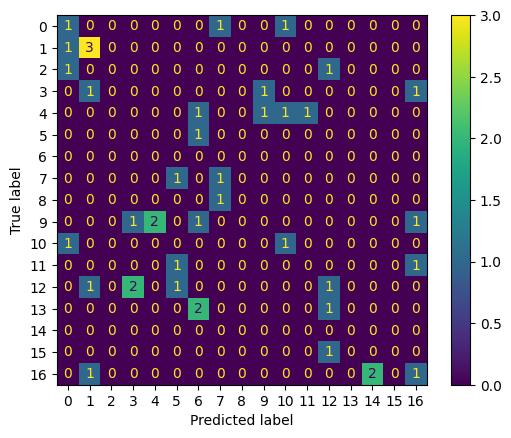

In [20]:
train_data, test_data = get_dataset(test,model_type='CNN', image_size=128)


model = keras.models.load_model('Trained Models/basic_CNN_Model_ExtraTrain.h5')


CNN.test_model(test_data, model, visualise=False)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 24ms/step
Shape of predictions: (42, 20)
Testing Accuracy: 0.2857142857142857


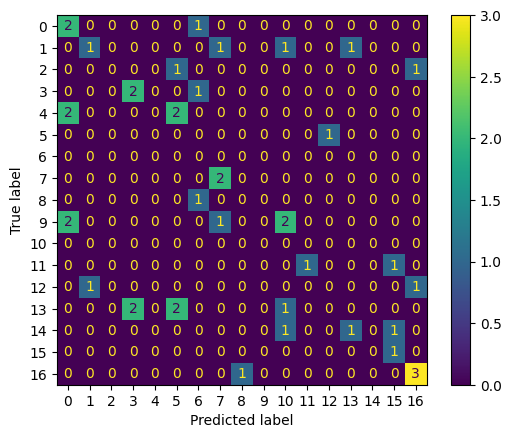

In [22]:
train_data, test_data = get_dataset(test,model_type='CNN', image_size=128)

training_start_time = time.time()
model = keras.models.load_model('/kaggle/input/saved-model-for-cnn/basic_CNN_Model_ExtraTrain.h5')
training_stop_time = time.time()

testing_start_time = time.time()
CNN.test_model(test_data, model, visualise=False)

In [23]:
train_data2_hog = read_images(train_images_path2, 'HOG', 64)
shuffle(train_data2_hog)
#model = keras.models.load_model('Trained Models/basic_CNN_Model.h5')
X_train, Y_train = HOG.generate_hog_features(train_data2_hog)
clf = LogisticRegression().fit(X_train, Y_train)
dump(clf, os.path.join('/Trained Models/', 'HOG_model2.joblib'))
#model.fit(X_train, Y_train, validation_split=0.2, epochs=15)
#model.save('Trained Models/basic_HOG_Model_ExtraTrain.h5')

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


['/Trained Models/HOG_model2.joblib']

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Testing Accuracy: 0.21428571428571427


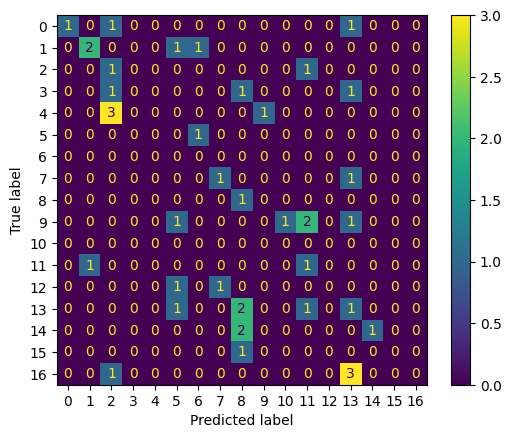

In [24]:
clf = load('/Trained Models/HOG_model2.joblib')
test='/kaggle/input/product-test'
train_data, test_data = get_dataset(test,model_type='HOG', image_size=64)

HOG.testModel(test_data, clf, visualise=False)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Testing Accuracy: 0.2619047619047619


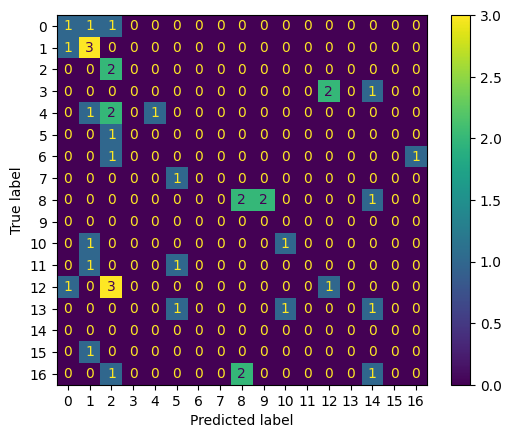

In [25]:
test='/kaggle/input/product-test'
train_data, test_data = get_dataset(test,model_type='HOG', image_size=64)
clf = HOG.generate_HOG_model(train_data)
HOG.testModel(test_data, clf, visualise=False)

In [ ]:
#os.remove('Trained Models/basic_CNN_Model.h5')